# Classificador de Frutas Utilizando SVM
## Análise baseada em características de Textura, Cor e Forma

In [27]:
import os
import cv2
import numpy as np
import pandas as pd
import mahotas
from skimage.feature import local_binary_pattern
import matplotlib.pyplot as plt
import xml.etree.ElementTree as ET
from sklearn import metrics
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, accuracy_score, f1_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler, label_binarize


In [4]:
bbox_file = "./docs/bbox_annotations.xml"

In [5]:
tabela_classes = {
    0: "acerola",
    1: "lemon",
    2: "cherry_tomato",
    3: "khaki",
    4: "banana",
    5: "lime",
    6: "clove_lemon",
    7: "avocado",
    8: "bergamot",
    9: "pear"
}

<h2>Carregamento e Processamento das Anotações</h2>
<ul>
    <li>A função <strong>carregar_anotações</strong> lê o arquivo XML e extrai as coordenadas (xmin, ymin, xmax, ymax) para cada imagem, armazenando-as em um dicionário.</li>
    <li>Em seguida, criamos um <strong>DataFrame</strong> do pandas para organizar essas informações de forma estruturada.</li>
    <li>As funções <strong>extrair_class_id</strong> e <strong>extrair_class_name</strong> ajudam a obter o nome da classe a partir do nome do arquivo, que é então adicionado ao DataFrame.</li>
</ul>

In [6]:
def carregar_anotacoes(caminho_do_xml):

    if not os.path.exists(caminho_do_xml):
        print(f"Arquivo de anotações não encontrado")
        return None

    tree = ET.parse(caminho_do_xml)
    root = tree.getroot()
    anotacoes = {}

    for image_elem in root.findall('image'):
        filename = image_elem.get('name')
        box_elem = image_elem.find('box')
        if filename is not None and box_elem is not None:
            xmin = int(float(box_elem.get('xtl')))
            ymin = int(float(box_elem.get('ytl')))
            xmax = int(float(box_elem.get('xbr')))
            ymax = int(float(box_elem.get('ybr')))
            anotacoes[filename] = {
                'xmin': xmin,
                'ymin': ymin,
                'xmax': xmax,
                'ymax': ymax
            }

    return anotacoes

In [7]:
anotacoes = carregar_anotacoes(bbox_file)
print(anotacoes)

{'0-01-V1-B.png': {'xmin': 125, 'ymin': 209, 'xmax': 206, 'ymax': 289}, '0-01-V1-W.png': {'xmin': 132, 'ymin': 218, 'xmax': 210, 'ymax': 288}, '0-01-V2-B.png': {'xmin': 127, 'ymin': 193, 'xmax': 219, 'ymax': 272}, '0-01-V2-W.png': {'xmin': 134, 'ymin': 194, 'xmax': 231, 'ymax': 282}, '0-02-V1-B.png': {'xmin': 117, 'ymin': 180, 'xmax': 220, 'ymax': 279}, '0-02-V1-W.png': {'xmin': 118, 'ymin': 211, 'xmax': 217, 'ymax': 302}, '0-02-V2-B.png': {'xmin': 125, 'ymin': 172, 'xmax': 204, 'ymax': 263}, '0-02-V2-W.png': {'xmin': 131, 'ymin': 191, 'xmax': 200, 'ymax': 277}, '0-03-V1-B.png': {'xmin': 126, 'ymin': 199, 'xmax': 209, 'ymax': 280}, '0-03-V1-W.png': {'xmin': 118, 'ymin': 188, 'xmax': 219, 'ymax': 288}, '0-03-V2-B.png': {'xmin': 136, 'ymin': 191, 'xmax': 202, 'ymax': 270}, '0-03-V2-W.png': {'xmin': 134, 'ymin': 204, 'xmax': 212, 'ymax': 296}, '0-04-V1-B.png': {'xmin': 123, 'ymin': 208, 'xmax': 187, 'ymax': 275}, '0-04-V1-W.png': {'xmin': 131, 'ymin': 212, 'xmax': 210, 'ymax': 295}, '0-04

In [8]:
def extrair_class_id(file_name):
    return int(file_name.split('-')[0])

def extrair_class_name(class_id):
    return tabela_classes.get(class_id, "unknown")

In [9]:
df_bbox = pd.DataFrame([
    {
        "file_name": file_name,
        "class_name": extrair_class_name(extrair_class_id(file_name)),
        "xmin": data["xmin"],
        "ymin": data["ymin"],
        "xmax": data["xmax"],
        "ymax": data["ymax"]
    }
    for file_name, data in anotacoes.items()
])

print(df_bbox)

         file_name class_name  xmin  ymin  xmax  ymax
0    0-01-V1-B.png    acerola   125   209   206   289
1    0-01-V1-W.png    acerola   132   218   210   288
2    0-01-V2-B.png    acerola   127   193   219   272
3    0-01-V2-W.png    acerola   134   194   231   282
4    0-02-V1-B.png    acerola   117   180   220   279
..             ...        ...   ...   ...   ...   ...
195  9-04-V2-W.png       pear    97   125   249   315
196  9-05-V1-B.png       pear   107   136   247   282
197  9-05-V1-W.png       pear    91   156   250   304
198  9-05-V2-B.png       pear    96   124   245   352
199  9-05-V2-W.png       pear   103   116   244   337

[200 rows x 6 columns]


<h2>Extração de Características (Features)</h2>
<ul>
    <li><b>Definição das Funções:</b> Criamos várias funções para extrair diferentes tipos de características das imagens:</li>
    <ul>
        <li><strong>Momentos de Hu:</strong> Descritores de forma.</li>
        <li><strong>Texturas de Haralick:</strong> Descritores de textura baseados em matrizes de co-ocorrência.</li>
        <li><strong>LBP (Local Binary Pattern):</strong> Outro descritor de textura robusto.</li>
        <li><strong>Histogramas RGB e HSV:</strong> Descritores de cor.</li>
        <li><strong>Estatísticas RGB:</strong> Média e desvio padrão dos canais de cor.</li>
    </ul>
    <li><b>Processamento Principal:</b> A função <strong>process_with_bbox_and_mask</strong> itera sobre cada imagem no DataFrame:</li>
    <ol>
        <li>Carrega a imagem original e sua máscara de segmentação (ground truth).</li>
        <li>Recorta a imagem usando a bounding box da anotação.</li>
        <li>Aplica a máscara para isolar a Região de Interesse (ROI), que é a fruta.</li>
        <li>Extrai todas as características definidas acima a partir da ROI.</li>
        <li>Armazena as características e os rótulos em um novo DataFrame <strong>df_features</strong>.</li>
        <li>A cada 10 imagens, uma visualização do recorte e da máscara é exibida para verificação.</li>
    </ol>
</ul>

In [10]:
def load_image_and_mask(image_dir, mask_dir, class_name, file_name):
    img_path = os.path.join(image_dir, class_name, file_name)
    mask_path = os.path.join(mask_dir, file_name)

    image = cv2.imread(img_path) 
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

    if image is None or mask is None:
        print(f"Erro ao carregar: {img_path} ou {mask_path}")
        return None, None
    
    return image, mask

In [11]:
def crop_and_mask(image, mask, bbox):
    x_min, y_min, x_max, y_max = bbox
    
    crop_img = image[y_min:y_max+1, x_min:x_max+1]
    crop_mask = mask[y_min:y_max+1, x_min:x_max+1]
    
    roi = cv2.bitwise_and(crop_img, crop_img, mask=crop_mask)
    
    return roi, crop_img, crop_mask

In [12]:
def extract_hu_moments(roi_gray):
    moments = cv2.moments(roi_gray)
    return cv2.HuMoments(moments).flatten()

def extract_haralick(roi_gray):
    return mahotas.features.haralick(roi_gray).mean(axis=0)

def extract_lbp(roi_gray, P=8, R=1):
    lbp = local_binary_pattern(roi_gray, P, R, method="uniform")
    (hist, _) = np.histogram(lbp.ravel(), bins=np.arange(0, P + 3), range=(0, P + 2))
    hist = hist.astype("float")
    hist /= (hist.sum() + 1e-6)
    return hist

def extract_rgb_histogram(roi, bins=8):
    chans = cv2.split(roi)
    features = []
    for chan in chans:
        hist = cv2.calcHist([chan], [0], None, [bins], [0, 256])
        hist = cv2.normalize(hist, hist).flatten()
        features.extend(hist)
    return features

def extract_hsv_histogram(roi, bins=8):
    hsv = cv2.cvtColor(roi, cv2.COLOR_BGR2HSV)
    chans = cv2.split(hsv)
    features = []
    for chan in chans:
        hist = cv2.calcHist([chan], [0], None, [bins], [0, 256])
        hist = cv2.normalize(hist, hist).flatten()
        features.extend(hist)
    return features

def extract_rgb_stats(roi):
    means = cv2.mean(roi)[:3]
    stds = [np.std(roi[:,:,i]) for i in range(3)]
    return list(means) + stds

In [13]:
def visualize_roi(crop_img, crop_mask, roi, file_name):
    crop_img_rgb = cv2.cvtColor(crop_img, cv2.COLOR_BGR2RGB)
    roi_rgb = cv2.cvtColor(roi, cv2.COLOR_BGR2RGB)

    fig, axs = plt.subplots(1, 3, figsize=(12,4))
    axs[0].imshow(crop_img_rgb)
    axs[0].set_title( "Crop Img")
    axs[1].imshow(crop_mask, cmap='gray')
    axs[1].set_title("Crop Mask")
    axs[2].imshow(roi_rgb)
    axs[2].set_title("Mask Applied")
    for ax in axs:
        ax.axis("off")
    plt.show()

In [14]:
def process_with_bbox_and_mask(df_bbox, image_dir, mask_dir, show_every=10):
    registros = []

    for idx, row in df_bbox.iterrows():
        file_name = row["file_name"]
        class_name = row["class_name"]
        bbox = (row["xmin"], row["ymin"], row["xmax"], row["ymax"])

        image, mask = load_image_and_mask(image_dir, mask_dir, class_name, file_name)
        if image is None or mask is None:
            continue
        
        roi, crop_img, crop_mask = crop_and_mask(image, mask, bbox)
        roi_gray = cv2.cvtColor(roi, cv2.COLOR_BGR2GRAY)

        hu = extract_hu_moments(roi_gray)
        har = extract_haralick(roi_gray)
        lbp = extract_lbp(roi_gray)
        rgb_hist = extract_rgb_histogram(roi)
        hsv_hist = extract_hsv_histogram(roi)
        rgb_stats = extract_rgb_stats(roi)

        registro = {
            "file_name": file_name,
            "class_name": class_name
        }
        for i, val in enumerate(hu):
            registro[f"hu_{i}"] = val
        for i, val in enumerate(har):
            registro[f"har_{i}"] = val
        for i, val in enumerate(lbp):
            registro[f"lbp_{i}"] = val
        for i, val in enumerate(rgb_hist):
            registro[f"rgb_hist_{i}"] = val
        for i, val in enumerate(hsv_hist):
            registro[f"hsv_hist_{i}"] = val
        for i, val in enumerate(rgb_stats):
            registro[f"rgb_stat_{i}"] = val

        registros.append(registro)

        if (idx + 1) % show_every == 0:
            print(f"{idx + 1}/{len(df_bbox)} imagens processadas")
            visualize_roi(crop_img, crop_mask, roi, file_name)

    df_features = pd.DataFrame(registros)
    return df_features

10/200 imagens processadas


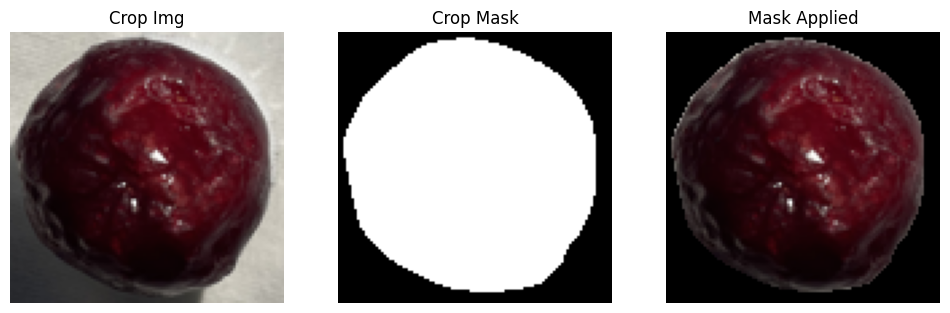

20/200 imagens processadas


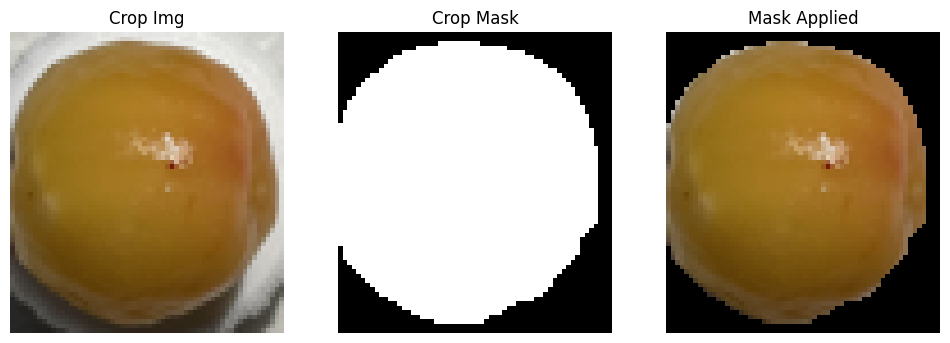

30/200 imagens processadas


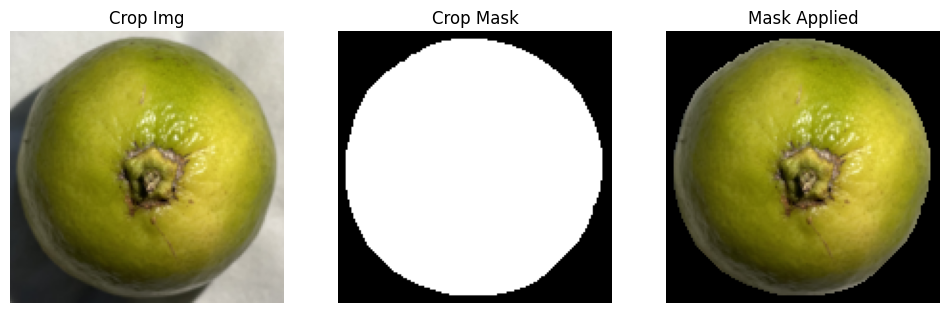

40/200 imagens processadas


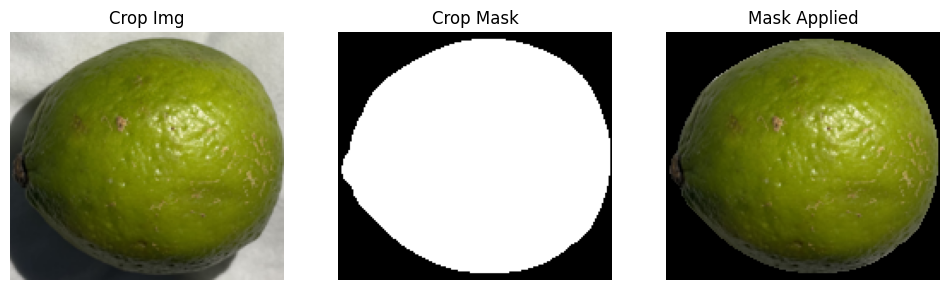

50/200 imagens processadas


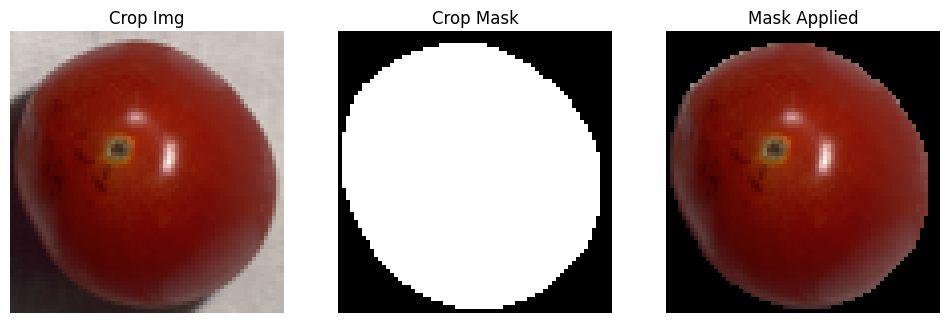

60/200 imagens processadas


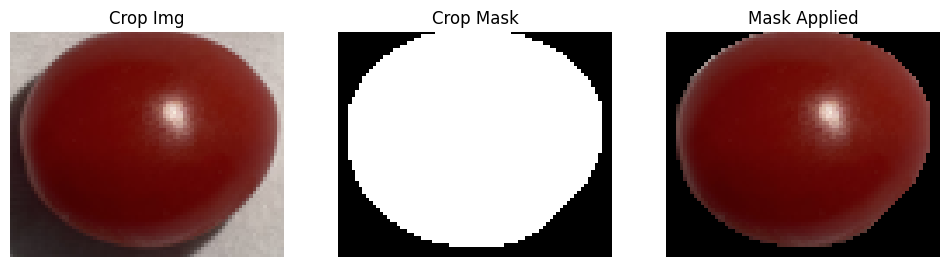

70/200 imagens processadas


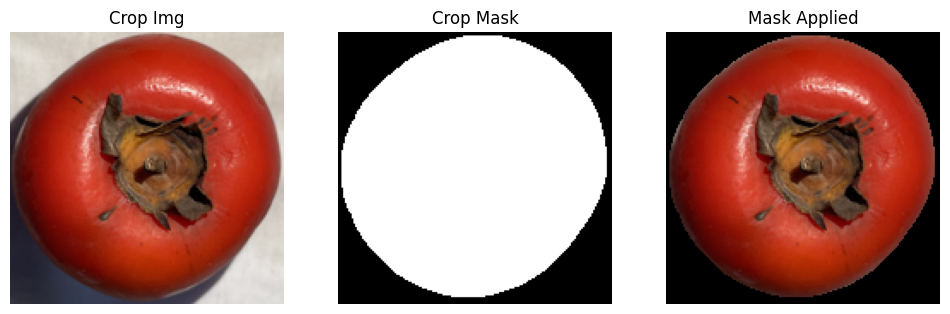

80/200 imagens processadas


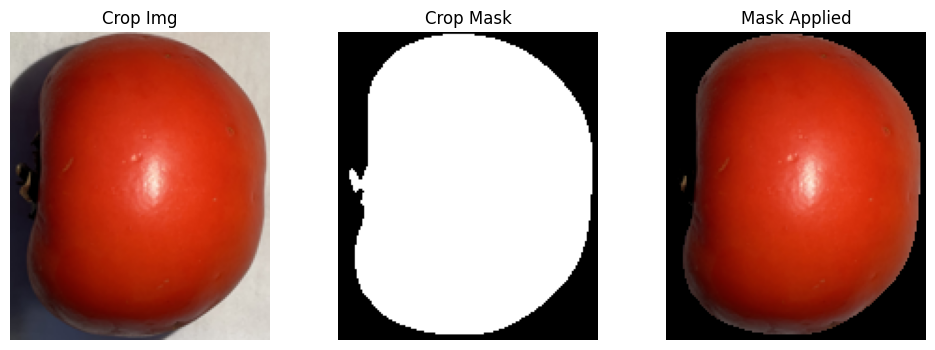

90/200 imagens processadas


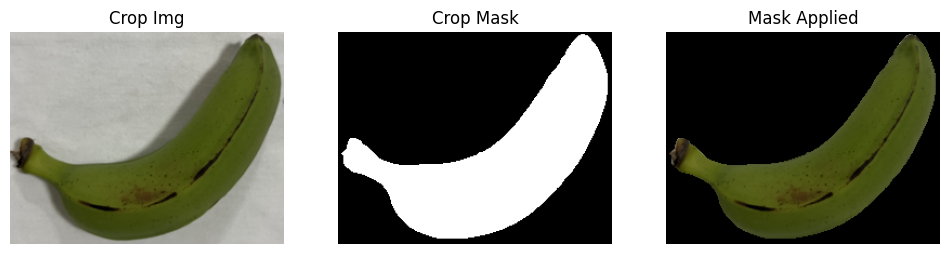

100/200 imagens processadas


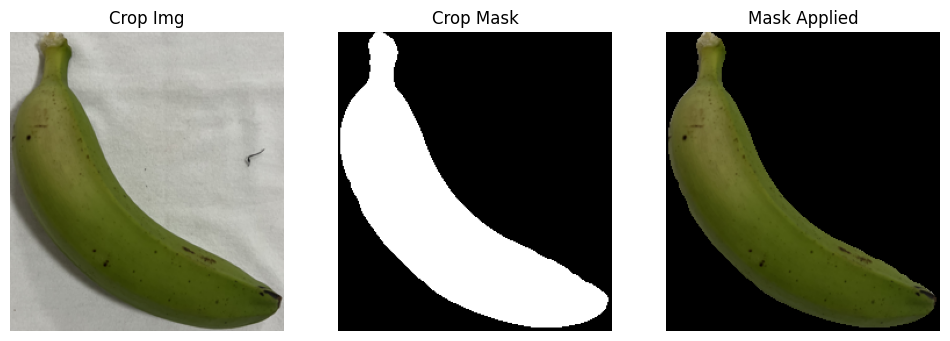

110/200 imagens processadas


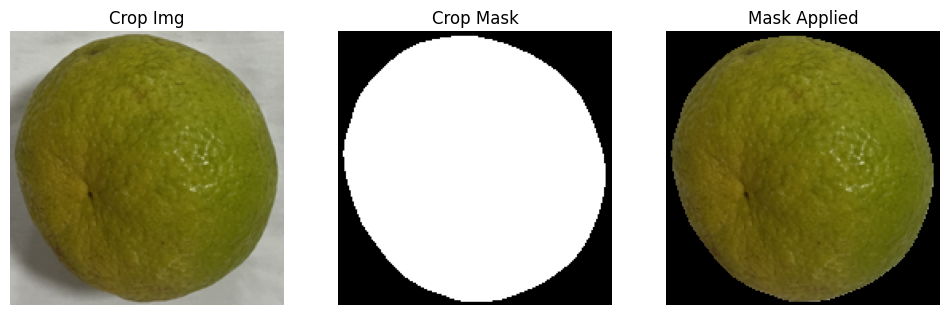

120/200 imagens processadas


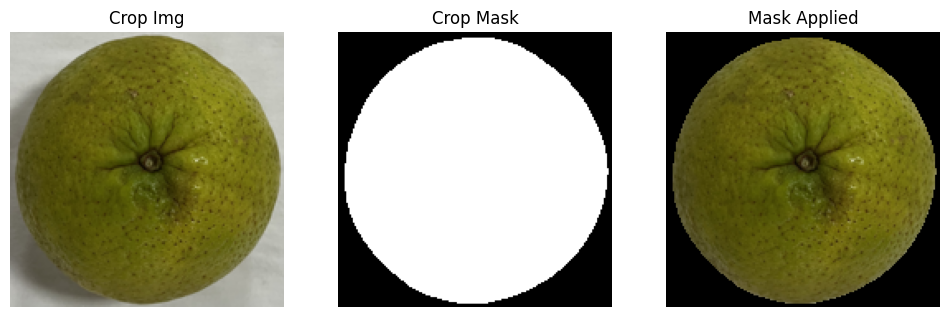

130/200 imagens processadas


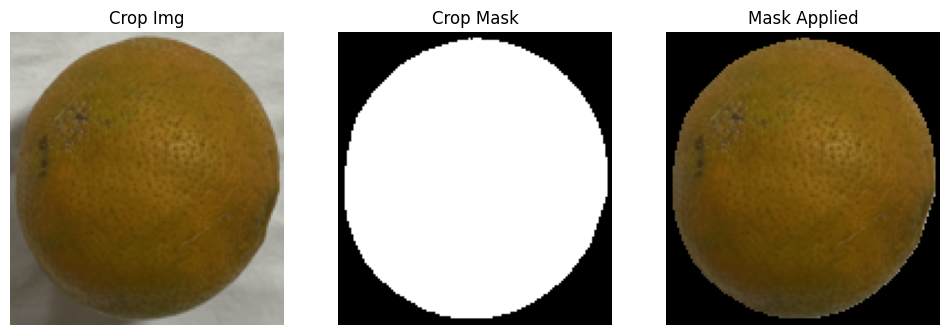

140/200 imagens processadas


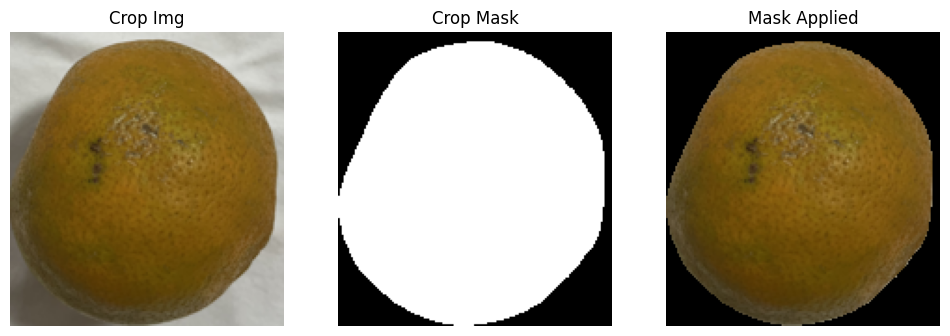

150/200 imagens processadas


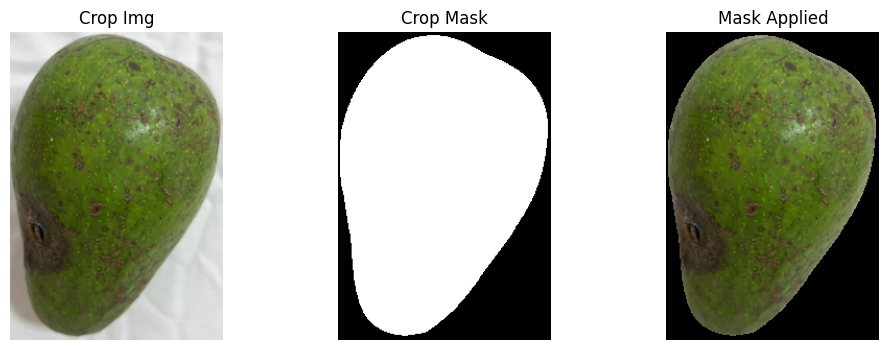

160/200 imagens processadas


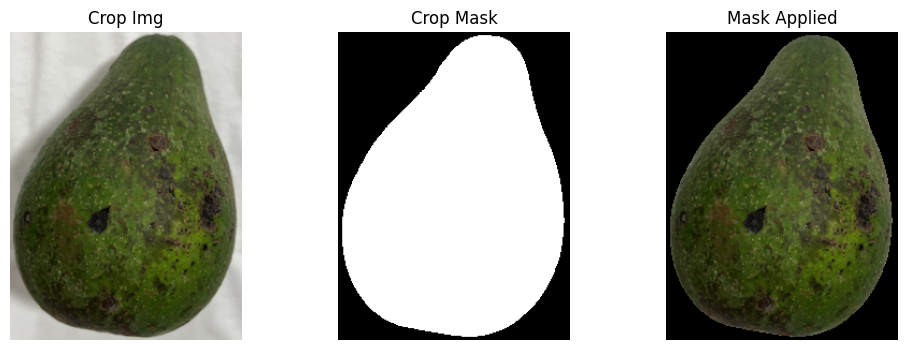

170/200 imagens processadas


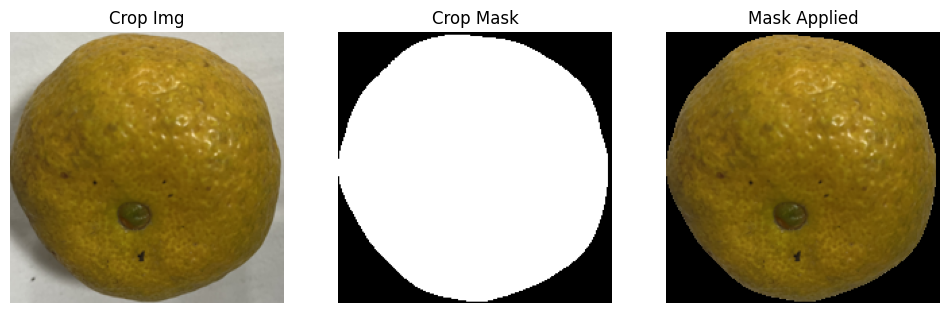

180/200 imagens processadas


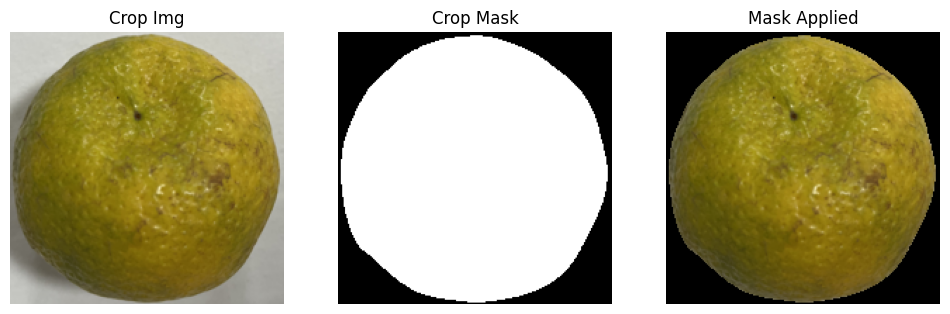

190/200 imagens processadas


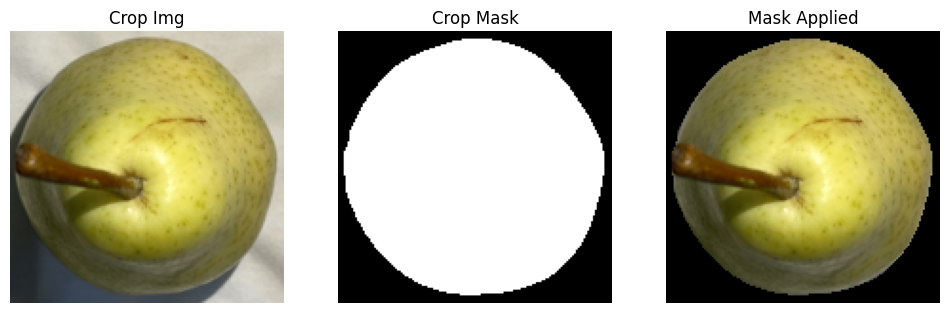

200/200 imagens processadas


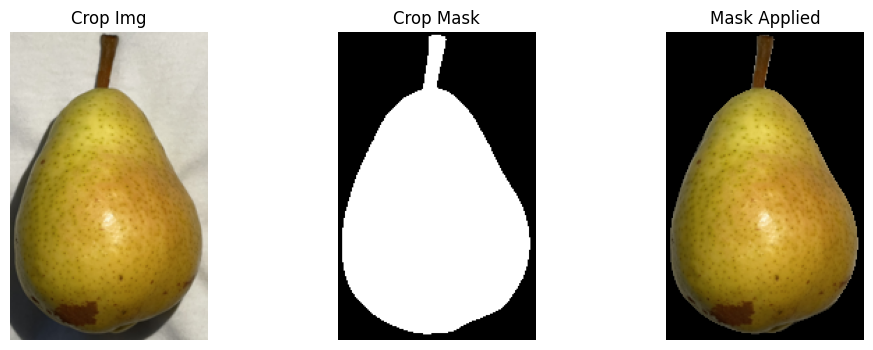

,file_name,class_name,hu_0,hu_1,hu_2,hu_3,hu_4,hu_5,hu_6,har_0,...,hsv_hist_20,hsv_hist_21,hsv_hist_22,hsv_hist_23,rgb_stat_0,rgb_stat_1,rgb_stat_2,rgb_stat_3,rgb_stat_4,rgb_stat_5
0,0-01-V1-B.png,acerola,0.001520,2.119767e-08,3.167320e-14,4.270847e-12,1.374449e-24,-6.214918e-16,-7.604322e-25,0.125173,...,0.030930,0.069461,0.240885,0.707453,36.444143,23.894610,136.629027,35.022056,36.770499,109.590714
1,0-01-V1-W.png,acerola,0.005757,1.965297e-07,4.790079e-10,2.140160e-09,-1.294868e-18,-4.366157e-13,-1.737473e-18,0.109999,...,0.003316,0.001206,0.000301,0.000000,11.815653,9.599216,38.408807,18.809123,18.988352,32.638398
2,0-01-V2-B.png,acerola,0.001532,9.650027e-08,3.328995e-11,2.399296e-11,-3.767832e-22,-1.265359e-16,5.637639e-22,0.086520,...,0.065044,0.074825,0.270937,0.759014,38.507661,29.685887,146.858737,32.394202,33.553502,105.424122
3,0-01-V2-W.png,acerola,0.003903,4.304797e-07,1.094789e-09,1.836931e-09,-1.912396e-18,-8.745274e-14,1.768804e-18,0.060853,...,0.060998,0.005355,0.004424,0.002328,22.158565,16.740083,63.300161,26.838865,27.388409,46.781317
4,0-02-V1-B.png,acerola,0.001163,1.488808e-08,7.624927e-12,3.682817e-12,-1.910363e-23,-2.389079e-16,-3.990116e-24,0.095277,...,0.035749,0.047320,0.343846,0.726030,33.755577,62.920000,146.533846,31.871736,53.930635,105.930231


In [15]:
image_dir = "fruits_classes"
mask_dir = "ground_truth"
df_features = process_with_bbox_and_mask(df_bbox, image_dir, mask_dir, show_every=10)
display(df_features.head())

In [16]:
df_features.to_csv("./docs/dataset_all_84_features.csv", index=False)

In [17]:
display(df_features)

,file_name,class_name,hu_0,hu_1,hu_2,hu_3,hu_4,hu_5,hu_6,har_0,...,hsv_hist_20,hsv_hist_21,hsv_hist_22,hsv_hist_23,rgb_stat_0,rgb_stat_1,rgb_stat_2,rgb_stat_3,rgb_stat_4,rgb_stat_5
0,0-01-V1-B.png,acerola,0.001520,2.119767e-08,3.167320e-14,4.270847e-12,1.374449e-24,-6.214918e-16,-7.604322e-25,0.125173,...,0.030930,0.069461,0.240885,0.707453,36.444143,23.894610,136.629027,35.022056,36.770499,109.590714
1,0-01-V1-W.png,acerola,0.005757,1.965297e-07,4.790079e-10,2.140160e-09,-1.294868e-18,-4.366157e-13,-1.737473e-18,0.109999,...,0.003316,0.001206,0.000301,0.000000,11.815653,9.599216,38.408807,18.809123,18.988352,32.638398
2,0-01-V2-B.png,acerola,0.001532,9.650027e-08,3.328995e-11,2.399296e-11,-3.767832e-22,-1.265359e-16,5.637639e-22,0.086520,...,0.065044,0.074825,0.270937,0.759014,38.507661,29.685887,146.858737,32.394202,33.553502,105.424122
3,0-01-V2-W.png,acerola,0.003903,4.304797e-07,1.094789e-09,1.836931e-09,-1.912396e-18,-8.745274e-14,1.768804e-18,0.060853,...,0.060998,0.005355,0.004424,0.002328,22.158565,16.740083,63.300161,26.838865,27.388409,46.781317
4,0-02-V1-B.png,acerola,0.001163,1.488808e-08,7.624927e-12,3.682817e-12,-1.910363e-23,-2.389079e-16,-3.990116e-24,0.095277,...,0.035749,0.047320,0.343846,0.726030,33.755577,62.920000,146.533846,31.871736,53.930635,105.930231
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,9-04-V2-W.png,pear,0.000960,1.062961e-08,3.728715e-11,1.599853e-12,6.673995e-25,-1.646429e-16,-1.233859e-23,0.149300,...,0.170880,0.267601,0.297949,0.166587,35.004346,88.899771,98.111282,35.474971,81.955273,89.647907
196,9-05-V1-B.png,pear,0.000914,3.395283e-10,3.083636e-13,2.874701e-13,-8.495841e-26,2.184914e-18,1.037462e-26,0.080836,...,0.133584,0.335438,0.636027,0.231912,32.296811,116.953587,131.617263,27.071055,83.119435,92.675657
197,9-05-V1-W.png,pear,0.001066,6.961100e-09,2.735206e-13,3.062320e-12,1.645344e-24,-1.998137e-16,2.268869e-24,0.113845,...,0.424786,0.250529,0.134670,0.169578,36.427139,88.207634,97.445889,35.452762,76.311278,82.385457
198,9-05-V2-B.png,pear,0.000980,1.254398e-07,1.112663e-10,7.626258e-12,2.111156e-22,2.626055e-15,-6.914794e-23,0.170698,...,0.030618,0.175272,0.551499,0.253277,27.852955,98.887598,117.468530,26.869009,88.224140,103.491885


<h2>Preparação dos Dados para o Modelo</h2>
<ul>
    <li><strong>Separação de Features e Rótulos:</strong> Separamos o DataFrame em <strong>X</strong> (matriz de características) e <strong>y</strong> (vetor de rótulos/classes).</li>
    <li><strong>Codificação dos Rótulos:</strong> Usamos o <strong>LabelEncoder</strong> para transformar os nomes das classes (texto) em números, que é o formato exigido pelo modelo SVM.</li>
    <li><strong>Escalonamento das Features:</strong> Aplicamos o <strong>StandardScaler</strong> para normalizar as características. Isso garante que todas as features tenham a mesma escala (média 0 e desvio padrão 1), o que é crucial para o bom desempenho do SVM.</li>
</ul>

In [18]:
X = df_features.drop(columns=["file_name", "class_name"])
y = df_features["class_name"]

In [19]:
le = LabelEncoder()
y_encoded = le.fit_transform(y)

In [20]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

<h2>Treinamento e Avaliação do Modelo SVM</h2>
<ul>
    <li><strong>Divisão dos Dados:</strong> Dividimos os dados em conjuntos de treino (80%) e teste (20%) usando <strong>train_test_split</strong>.</li>
    <li><strong>Criação e Treinamento do Modelo:</strong> Instanciamos o classificador <strong>SVC (Support Vector Classifier)</strong> e o treinamos com os dados de treino escalonados (<code>X_train</code>, <code>y_train</code>).</li>
    <li><strong>Previsão e Avaliação:</strong> Usamos o modelo treinado para fazer previsões no conjunto de teste.</li>
    <li><strong>Métricas de Desempenho:</strong></li>
    <ul>
        <li>Calculamos a <strong>acurácia</strong> para ter uma visão geral do desempenho.</li>
        <li>Geramos um <strong>relatório de classificação</strong>, que mostra métricas detalhadas como precisão, recall e f1-score para cada classe.</li>
        <li>Criamos e exibimos uma <strong>matriz de confusão</strong> para visualizar onde o modelo está acertando e errando nas suas previsões.</li>
    </ul>
</ul>

In [21]:
X_train, X_temp, y_train, y_temp = train_test_split(X_scaled, y_encoded, test_size=0.2, stratify=y_encoded, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42)

In [22]:
svm = SVC()
svm.fit(X_train, y_train)

,C,1.0
,kernel,'rbf'
,degree,3
,gamma,'scale'
,coef0,0.0
,shrinking,True
,probability,False
,tol,0.001
,cache_size,200
,class_weight,None
,verbose,False


In [23]:
y_pred = svm.predict(X_test)

In [24]:
acc = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='macro')

print(
    f"Classification report {svm}:\n"
    f"{metrics.classification_report(y_test, y_pred)}\n"
)

print(f"Acurácia média: {acc:.4f}")
print(f"F1-score: {f1:.4f}")

Classification report SVC():
              precision    recall  f1-score   support

           0       0.67      1.00      0.80         2
           1       1.00      1.00      1.00         2
           2       1.00      1.00      1.00         2
           3       1.00      1.00      1.00         2
           4       1.00      1.00      1.00         2
           5       1.00      0.50      0.67         2
           6       1.00      1.00      1.00         2
           7       1.00      1.00      1.00         2
           8       1.00      1.00      1.00         2
           9       1.00      1.00      1.00         2

    accuracy                           0.95        20
   macro avg       0.97      0.95      0.95        20
weighted avg       0.97      0.95      0.95        20


Acurácia média: 0.9500
F1-score: 0.9467


Confusion matrix:
[[2 0 0 0 0 0 0 0 0 0]
 [0 2 0 0 0 0 0 0 0 0]
 [0 0 2 0 0 0 0 0 0 0]
 [0 0 0 2 0 0 0 0 0 0]
 [0 0 0 0 2 0 0 0 0 0]
 [1 0 0 0 0 1 0 0 0 0]
 [0 0 0 0 0 0 2 0 0 0]
 [0 0 0 0 0 0 0 2 0 0]
 [0 0 0 0 0 0 0 0 2 0]
 [0 0 0 0 0 0 0 0 0 2]]


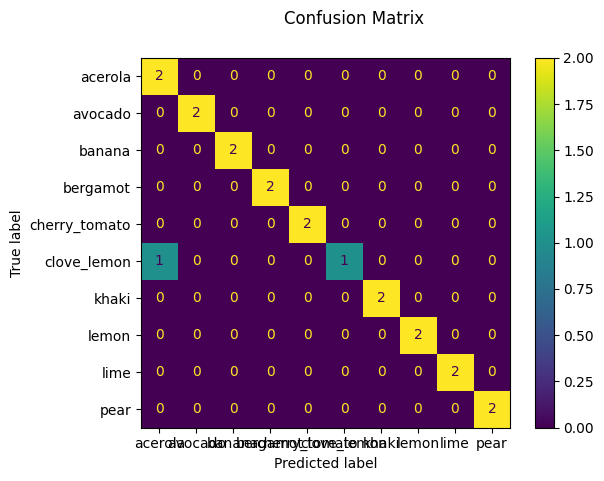

In [25]:
disp = metrics.ConfusionMatrixDisplay.from_predictions(y_test, y_pred,display_labels=le.classes_)
disp.figure_.suptitle("Confusion Matrix")
print(f"Confusion matrix:\n{disp.confusion_matrix}")
plt.show()

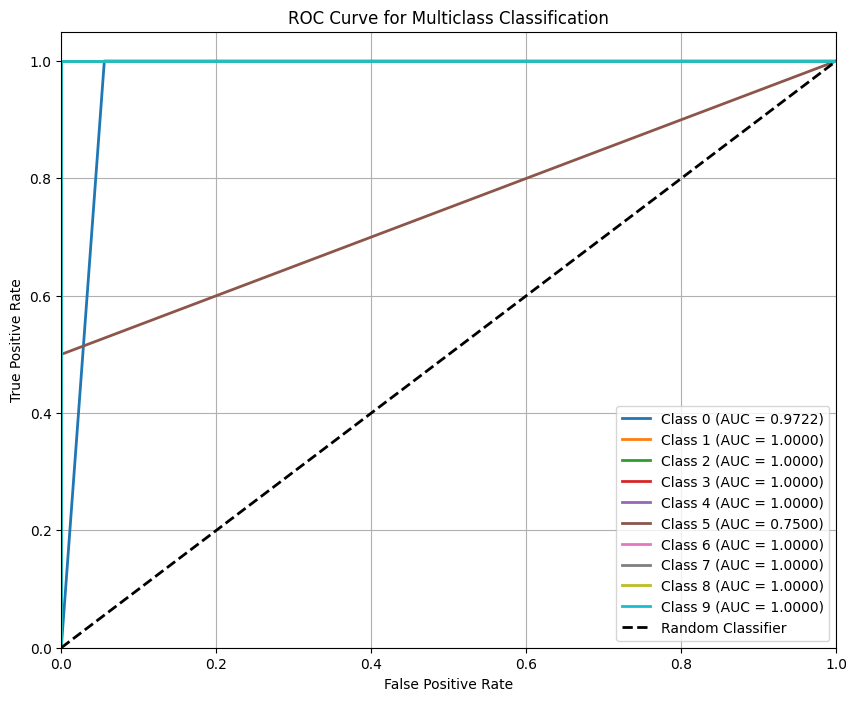

In [45]:
y_test_binarized = label_binarize(y_test, classes=np.unique(y_test))
y_pred_binarized = label_binarize(y_pred, classes=np.unique(y_test))

fpr = dict()
tpr = dict()
roc_auc = dict()
n_classes = y_test_binarized.shape[1]

for i in range(n_classes):
    fpr[i], tpr[i],_ = roc_curve(y_test_binarized[:, i], y_pred_binarized[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(10, 8))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], lw=2, label=f'Class {i} (AUC = {roc_auc[i]:.4f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Random Classifier')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Multiclass Classification')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()